In [1]:
import numpy as np
import scipy
import skfem    
#https://scikit-fem.readthedocs.io/en/latest/index.html

import matplotlib.pyplot as plt
#import importlib  # for reloading routines
%matplotlib inline


The Swift-Hohenberg model is 
\begin{align}
\partial_t u = r u -  (1 + \Delta)^2 u + \gamma_u u^2 - u^3
\end{align}

The weak/variational form of the problem is 
\begin{align}
\int_\Omega \partial_t u\ w\ dx &= \int_\Omega ( (r-1) u - 2 \Delta u - \Delta^2 u  ) w \ dx + \int_\Omega g(u) \ w \ dx\\
\end{align}
with function $$g(u) = \gamma_u u^2- u^3$$  and test function $w \in \hat V$ where $\hat V$ is a Sobolev space to be determined. 

It will probably be easier to do the integration by parts with index notation. 
$\Delta = \sum_i \partial_{ii}$, $\Delta^2 = \sum_{ij} \partial_{iijj} $. 

We twice integrate by parts the term with $\Delta^2$. 
\begin{align}
\int_\Omega \Delta^2 u \ w dx &= \int_\Omega  \sum_{ij} (\partial_{iijj} u) w dx \\
& = -  \int_\Omega \sum_{ij} \partial_{ijj} u \partial_i w   \ dx 
+ \int_{\partial \Omega} \Delta^2 u\ w \ ds\\
 & = \int_\Omega \sum_{ij} \partial_{ij} u \partial_{ij} w \ dx
- \int_{\partial \Omega} \sum_{ij} (\partial_i w) (\partial_{ij} u) \ ds_j
  +  \int_{\partial \Omega} \Delta^2 u\ w \ ds\\
\end{align}

If $\Delta^2 u=0$ and all components of $\partial_{ij} u = 0$ then the boundary terms are zero. 
Apparently our test functions $w \in H^2(\Omega)$ which means we need a fancy element. 
With skfem that means using the Morley element. 

What do we do with the Laplacian term $\Delta u$? Ordinarily we would do this:
$$\int_{\Omega} \Delta u w dx = - \int_{\Omega} \nabla u \nabla w \ dx + \int_{\partial \Omega} \partial_n u w ds  $$
But this gives a boundary term that conflicts with our two boundary terms we have from the biharmonic term. 

So we don't do that. Instead we use weak form 

\begin{align}
\int_\Omega \partial_t u\ w\ dx 
 & =  \int_\Omega  ((1-r)u - 2 \nabla u) w \ dx 
 - \int_\Omega \sum_{ij} \partial_{ij} u \partial_{ij} w \ dx
+ \int_{\partial \Omega} \sum_{ij} (\partial_i w) (\partial_{ij} u) \ ds_j
  -  \int_{\partial \Omega} \Delta^2 u\ w \ ds\\
\end{align}


We can operator split with 
$L = (r-1) - 2\Delta - \Delta^2$ and function $g(u)$. 

We discretise the problem using the non-conforming Morley finite element <https://users.aalto.fi/~jakke74/WebFiles/Slides-Niiranen-ADMOS-09.pdf> which is a piecewise quadratic $C^0$-continuous element for biharmonic problems. The basis is apparently $H^2$. 

In [4]:
from scipy.sparse.linalg import splu  # for sparse matrices, 
# returns something like invA with LU decomp which can be applied with solve to solve Ax = b for x

from skfem.models.poisson import mass
from skfem.visuals.matplotlib import plot
from skfem import BilinearForm

# display,  calls skfem's plot routine 
def disp(mesh,u,basis,t):
    fig,ax = plt.subplots(1,1,figsize=(6,3),sharex=True,sharey=True)
    ax.set_aspect('equal'); 
    u_mag = u[basis.nodal_dofs.flatten()]  
    ax_j0 = plot(mesh, u_mag, shading='gouraud', ax = ax)
    fig = ax.get_figure()
    field0 = ax.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0,shrink=0.8)
    title = ax.set_title(f'$t$ = {t:.3f}')


In [6]:

mcircs= skfem.MeshTri.init_circle(6,smoothed=False)  # make a triangular mesh of the unit circle, 5 is refinement level
rmax = 25.
#mcirc = skfem.MeshTri(mcircs.p*rmax,mcircs.t)  # expand the mesh to be larger 
mcirc = mcircs.translated(rmax * mcircs.p) # expand the mesh to be larger 
# now it is a circle of radius rmax
mcirc # show the mesh
#plt.plot(mcirc.p[0],mcirc.p[1],'.')  # plot points in the mesh

In [12]:
# make the basis
element = skfem.ElementTriMorley()  #  we need a fancy Morley element for biharmonic problems. 
basis = skfem.Basis(mcirc, element)  # could add intorder=?
D=basis.get_dofs() # automatically find boundary, just in case you want to experiment with it
#bdofs = basis.get_dofs(lambda x: np.sqrt(x[0]**2 + x[1]**2) > rmax - epsilon), this also would have worked 
# d_basis = skfem.FacetBasis(D,element) 

In [18]:
r=0.2 # control parameter is needed in the bilinear form 
gammau = 0.0  # for g(u)
dt = 0.05  # for making operators

@BilinearForm  # for info on forms see https://scikit-fem.readthedocs.io/en/latest/advanced.html#forms
def bilinf(u, v, w):  # The last argument w is a dictionary thing associated with the fields and elements 
    from skfem.helpers import  dot, grad, ddot, dd, trace  #  f3 equivalent to  ddot(C(dd(u)), dd(v))
    f3 = -1*ddot(u.hess, v.hess)   # ddot of hessians is  \sum_{ij} \partial_{ij} u \partial_{ij} v 
    #equivalent to np.einsum('ij,ij', u.hess, v.hess)
    #f2 = +2*dot(grad(u), grad(v))  # this was 2*laplacian conventionally and is a bad idea 
    f2 = -2*trace(u.hess)*v  # this is 2 times the laplacian
    f1 = (r-1.)*u*v   
    return (f1+f2+f3)

# the extra function:
def g(u,gammau):
    return gammau*u**2 -(u**3)

# assemple the operators with the basis!
M = skfem.asm(mass, basis)  # mass matrix is a bilinear form of u,v returning u*v
L = skfem.asm(bilinf, basis)

#L0, M0 = skfem.penalize(L, M, D=D)  # boundary condition used here for u = 0, du/dn = 0 boundary  
#L0, M0 = skfem.enforce(L,  M, D=D);
L0, M0 = L, M  # Neumann like BC (natural ones involved doing nothing)
theta = 0.5         # Crank–Nicolson algorithm for a diffusion PDE
A = M0 - theta * L0 * dt   #not flipping sign of bilinear form here 
B = M0 + (1. - theta) * L0 * dt

backsolve = splu(A.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)
# is like A inverse but is applied with solve 

In [16]:
# op split integrator, crank nicholson for the diffusion and biharmonic parts and simply adding in the 
# non-linear function terms by hand afterwards 
# do a single timestep, return u field and time 
# requires globals: dt, backsolve,  B
# note r,dt is used in definition of B and backsolve 
def one_step(t,u,gammau):
    t += dt
    u = backsolve(B @ u)    
    u += g(u,gammau)*dt
    return t,u


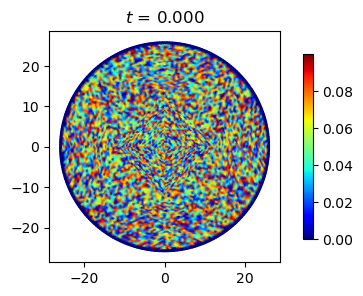

In [20]:
# make random initial conditions for u field
nnodes = len(basis.doflocs[0])
u_init = np.zeros(nnodes)
r2nodes = np.sqrt(basis.doflocs[0,:]**2 +  basis.doflocs[1,:]**2)
for i in range(nnodes):
    if (r2nodes[i] <1.01*rmax):
        u_init[i] = 1e-1*np.random.uniform(low=0,high=1)  # if you want to only set nodes in the center 
# show initial conditions 
t=0
disp(mcirc,u_init,basis,t)  #display initial conditions 

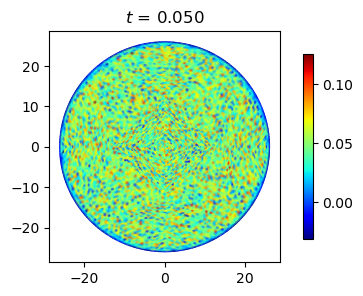

In [22]:
u = u_init;  t=0; 
for i in range(1):
    t, u = one_step(t,u,gammau)  
disp(mcirc,u,basis,t)

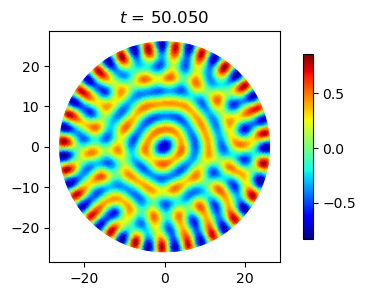

In [24]:
for i in range(1000):
    t, u = one_step(t,u,gammau)  
disp(mcirc,u,basis,t)

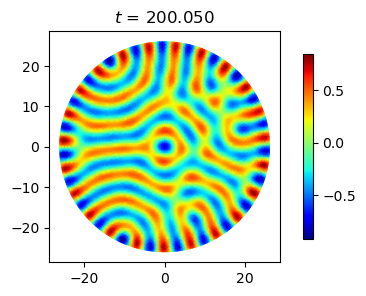

In [30]:
for i in range(1000):
    t, u = one_step(t,u,gammau)  
disp(mcirc,u,basis,t)

In [ ]:
# not too bad! looks ok!

In [32]:
# trying a different set of parameters 
r=0.2 # control parameter is needed in the bilinear form 
gammau = 1.0  # for g(u)
dt = 0.05  # for making operators

@BilinearForm
def bilinf(u, v, w):
    from skfem.helpers import  dot, grad, ddot, dd, trace  #  f3 equivalent to  ddot(C(dd(u)), dd(v))
    f3 = -1*ddot(u.hess, v.hess)   # ddot of hessians is  \sum_{ij} \partial_{ij} u \partial_{ij} v 
    #equivalent to np.einsum('ij,ij', u.hess, v.hess)
    #f2 = +2*dot(grad(u), grad(v))  # this was 2*laplacian conventionally and is a bad idea 
    f2 = -2*trace(u.hess)*v  # this is 2 times the laplacian
    f1 = (r-1.)*u*v   
    return (f1+f2+f3)

# the extra function:
def g(u,gammau):
    return gammau*u**2 -(u**3)

# assemple the operators with the basis!
M = skfem.asm(mass, basis)  # mass matrix is a bilinear form of u,v returning u*v
L = skfem.asm(bilinf, basis)

#L0, M0 = skfem.penalize(L, M, D=D)  # boundary condition used here for u = 0, du/dn = 0 boundary  
#L0, M0 = skfem.enforce(L,  M, D=D);
L0, M0 = L, M  # Neumann like BC (natural ones involved doing nothing)
theta = 0.5         # Crank–Nicolson algorithm for a diffusion PDE
A = M0 - theta * L0 * dt   #not flipping sign of bilinear form here 
B = M0 + (1. - theta) * L0 * dt

backsolve = splu(A.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)
# is like A inverse but is applied with solve 

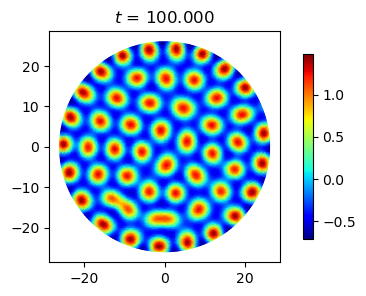

In [38]:
u = u_init;  t=0; 
for i in range(2000):
    t, u = one_step(t,u,gammau)  
disp(mcirc,u,basis,t)

In [ ]:
# sweet!

In [ ]:
# check the boundary in D
#xb = basis.doflocs[0,D.nodal['u']]
#yb = basis.doflocs[1,D.nodal['u']]
#fig,ax = plt.subplots(1,1,figsize=(2,2))
#ax.plot(xb,yb,'.')
#ax.set_aspect('equal')
#?D